In [25]:
import scipy as sc
from scipy import optimize as op
import math as m
import matplotlib as mp
from matplotlib import pyplot as pl
import datetime as d
import numpy as np
from numpy import random as r
import os
import string
#import ok
def test_func(x, a, b, c, d):
    return ((a * np.sin((b * x)+c)+d))

In [26]:
run_start = d.datetime.utcnow(); #Use this if this notebook initiates the data collection, 
                                 #this line records the start time
run_start=run_start.strftime('%m_%d_%Y_%H_%M_%S_%f'); #Format of timestamp is month_day_year_minute_second_microsecond
filename= 'chronopixel_hits_%s.npz' %run_start; #Files will be named chronopixel_hits_<run_start>.npz
#run_start = 'ex' Use if you wish to manually input the run start

In [27]:
thres_volt='10 mV'; #This section will be used to input different pieces of metadata
comment='Fill with any comments';
temp='ex';
freq='50MHz';                    #Should be changed if a different clock speed is used
metadata=np.chararray((6,2), unicode=True, itemsize=60); #This creates a numpy character array to store the metadata
metadata[0][0]='filename'; #The rest of this cell is just filling the array with the metadata
metadata[0][1]=filename; #The first column will be the type of data stored
metadata[1][0]="Date & Time"; #The second column will be the actual values
metadata[1][1]=run_start;
metadata[2][0]="Threshold Voltage";
metadata[2][1]=thres_volt;
metadata[3][0]="Temperature";
metadata[3][1]=temp;
metadata[4][0]="Clock Frequency";
metadata[4][1]=freq;
metadata[5][0]="Run Comments";
metadata[5][1]=comment;
print(metadata);

[['filename' 'chronopixel_hits_06_15_2018_13_05_01_767303.npz']
 ['Date & Time' '06_15_2018_13_05_01_767303']
 ['Threshold Voltage' '10 mV']
 ['Temperature' 'ex']
 ['Clock Frequency' '50MHz']
 ['Run Comments' 'Fill with any comments']]


In [28]:
#These next two cells are prototypes for reading in the data
data=r.randint(2, size=(24570,400)); #This creates a random binary array representing the data
runs=int(len(data[:,0])/4095); #This determines the number of chronopixel readouts that the data file contains
test_data= np.empty([4095, 400, runs]); #Creates an empty array 3D array to store the data
for n in range(runs): #This section stores the data in the 3D array. The x-axis is the timestamp number, 
    #the y-axis is the pixel number and the z-axis is the readout number
    for m in range((n*4095),((n+1)*4095)):
        for i in range(400):
            test_data[(m-(n*4095))][i][n]=data[m][i];

In [29]:
#Original prototype
#test_data = np.empty([4095,400,runs]); 
#test_data = r.randint(2, size=(4095,400,runs))
#run_store = np.savez('chronopixel_run_%s' %run_start, test_data); 
#time=[n for n in range(4095)];
#print('chronopixel_run_%s' %run_start);

In [47]:
time=np.empty([runs,4095]); #Creates an empty array for the timestamp relative to the start of the run
for n in range(runs):
    for m in range(4095):
        time[n][m]=(n*4095)+m #This creates a timestamp for each readout relative to the beginning of the run
hits=np.empty([runs,len(test_data[:,0,0])]); #This array will store the total number of hits at each point in time
for n in range(runs): #x-axis is the run number and y-axis is the timestamp
    for m in range(len(test_data[:,0,0])):
        hits[n][m]=sum(test_data[m,:,n]); #This sums the hits over all the pixels at time m
path=u'/Users/walterwilson/Chronopixel_Data_Analysis/%s'%filename; #This is the directory the files will be stored in
#Currently I am storing the files to the location of my Python notebooks
file= np.savez_compressed(filename, data=hits, time=time, meta=metadata); #Creating a compressed file with the data,
#timestamp and the metadata which is saved to the previously mentioned directory
opened_file = np.load(filename); #Opening the created file and checking the arrays
print(type(opened_file['data']));

<class 'numpy.ndarray'>


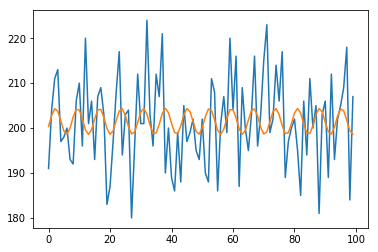

[  -2.89559788    0.87768813    2.73892387  201.48462363]


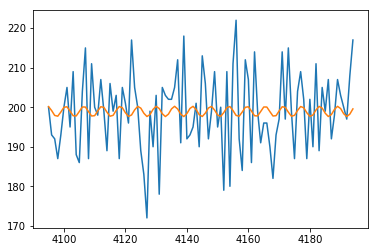

[   1.29776367    1.06490611 -180.56859636  198.93385163]


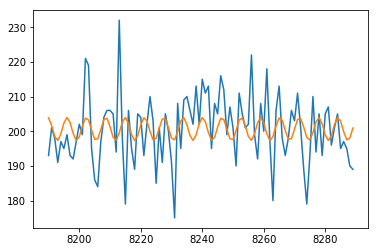

[   3.32091359    0.99777434   17.05634051  200.6409502 ]


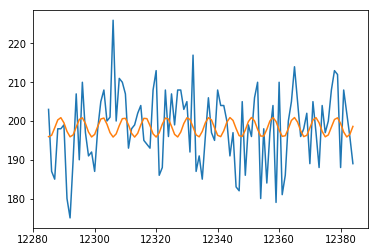

[ -2.52576908e+00   9.08358088e-01   1.13199871e+03   1.98384428e+02]


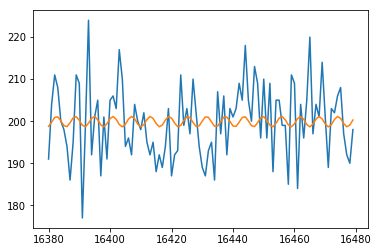

[  -1.240693      1.03011559 -459.60564839  199.889468  ]


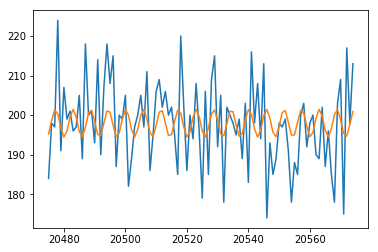

[ -3.50023978e+00   1.09819875e+00  -2.01276853e+03   1.97946968e+02]


In [42]:
for n in range(runs): #Plotting the number of recorded hits at each timestamp for each of the readouts
    y=hits[n,0:100];
    #Fitting a sine wave to the data of the formula a*sin((b*x)-c)+d
    params, params_covariance = op.curve_fit(test_func, time[n,0:100], y, method='lm'); 
    pl.plot(time[n,0:100], y);
    pl.plot(time[n,0:100], test_func(time[n,0:100], params[0], params[1], params[2], params[3]));
    pl.show();
    print(params);

In [32]:
avr_hits=np.empty(len(hits[:,0])) #Finding the average number of detected hits for each readout
for n in range(len(hits[:,0])):
    avr_hits[n]=sum(hits[n,:])/len(hits[n,:])
print(avr_hits);

[ 199.85616606  200.07863248  199.9995116   200.32112332  199.96190476
  199.79291819]


In [35]:
def save(data, start, thres_volt="10 mV", comment='Fill with any comments',temp='ex',
freq='50MHz'):
    filename= 'chronopixel_hits_%s.npz' %start;
    metadata=np.chararray((6,2), unicode=True, itemsize=60); 
    metadata[0][0]='filename'; 
    metadata[0][1]=filename;
    metadata[1][1]=run_start;
    metadata[2][0]="Threshold Voltage";
    metadata[2][1]=thres_volt;
    metadata[3][0]="Temperature";
    metadata[3][1]=temp;
    metadata[4][0]="Clock Frequency";
    metadata[4][1]=freq;
    metadata[5][0]="Run Comments";
    metadata[5][1]=comment;
    runs=int(len(data[:,0])/4095); 
    data_array= np.empty([4095, 400, runs]); 
    for n in range(runs):
        for m in range((n*4095),((n+1)*4095)):
            for i in range(400):
                data_array[(m-(n*4095))][i][n]=data[m][i];
    time=np.empty([runs,4095]); 
    for n in range(runs):
        for m in range(4095):
            time[n][m]=(n*4095)+m 
    hits=np.empty([runs,len(test_data[:,0,0])]); 
    for n in range(runs): 
        for m in range(len(test_data[:,0,0])):
            hits[n][m]=sum(test_data[m,:,n]); 
    path=u'/Users/walterwilson/Chronopixel_Data_Analysis/%s'%filename; 
    file= np.savez_compressed(filename, data=hits, time=time, meta=metadata);
    return(start, runs, path)

In [50]:
def hits_plot(path, runs, begin=0, end=-1):
    opened_file=np.load(path);
    for n in range(runs): #Plotting the number of recorded hits at each timestamp for each of the readouts
        y=opened_file['data'][n,begin:end];
        time=opened_file['time'];
        params, params_covariance = op.curve_fit(test_func, time[n,begin:end], y, method='lm'); 
        pl.plot(time[n,begin:end], y);
        pl.plot(time[n,begin:end], test_func(time[n,begin:end], params[0], params[1], params[2], params[3]));
        pl.show();
        print(params);

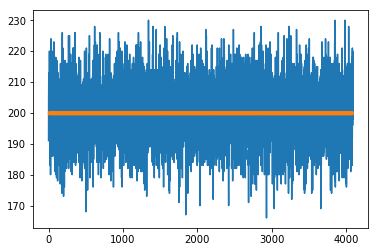

[   0.40205508    1.00166055   -0.39144907  199.85498826]


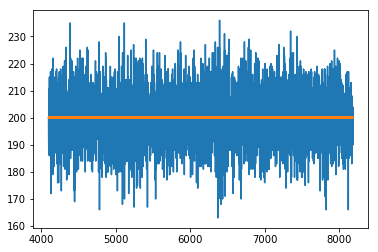

[  -0.22766178    1.00102294   -5.66491427  200.08009297]


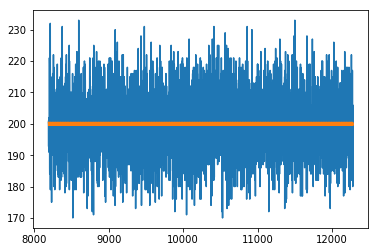

[  -0.41981299    1.00007663   -4.98434276  200.00027024]


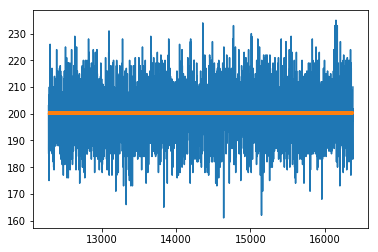

[   0.45962674    0.99999129   -3.28105775  200.32110595]


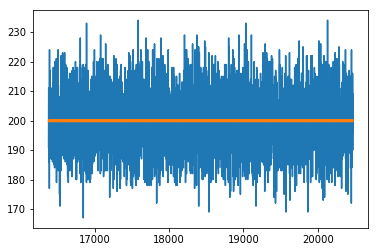

[   0.29321235    0.98629504  246.98625932  199.96007274]


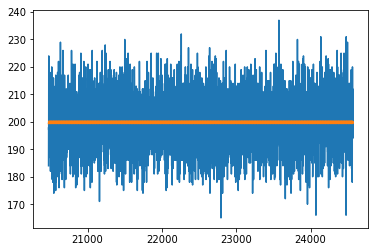

[  -0.39208039    0.99911137   21.67181305  199.79360113]


In [51]:
start,runs,path=save(data, run_start);
hits_plot(path, runs);